In [59]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import random
import pandas as pd
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import networkx as nx
import sounddevice as sd

In [60]:
D = 1e3
P = 1e3
L = 1e3
r = 250
d_max = 1200
BS = [P/2, L/2, 0]

N = 48
f = 4e4
pH = 7.7         
sh = 0.55
T = 4     
S = 34     
w = 5  
k = 2
spreading_factor = 1.5
m = 10

kc = 1
kd = 2500
kt = kd + N
beta = 0.8
data_rate = 500 # bps
t_transmission =  ((kd * 8)/data_rate) + ((kc * 8)/data_rate) + (((kc + N) * 8)/data_rate)
initial_energy = 1
E_elec = 50 * 1e-9
P_tx = 1e-3
p = 0.05

In [61]:
def generate_sound(frequency, duration, sample_rate=44100):
    t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    audio = np.sin(2 * np.pi * frequency * t)
    return audio

def play_sound(sound, sample_rate=44100):
    sd.play(sound, samplerate=sample_rate)
    sd.wait()

# Set the frequency and duration of the sound
desired_frequency = 880  # Change this to your desired frequency in Hz
desired_duration = 1      # Change this to your desired duration in seconds

# Generate the sound
sound = generate_sound(desired_frequency, desired_duration)



In [62]:
def vibrationFrequencies(show_info = False):
    f1 = 0.78 * np.sqrt(S/35) * np.exp(T/26)
    f2 = 42 * np.exp(T/17)

    if show_info: 
        print(f"F1 : {f1:.2f} | f2 : {f2:.2f}")

    return f1, f2

f1, f2 = vibrationFrequencies(show_info = False)
def attenuationConstant(D, show_info = False):
    D_km = D/1e3
    f1_kHz = f1/1e3
    f2_kHz = f2/1e3
    f_kHz = f/1e3

    term1 = 0.106 * (f1_kHz * f_kHz**2) / (f1_kHz**2 + f_kHz**2) * np.exp((pH - S) / 0.56)
    term2 = 0.52 * (1 + (T / 43)) * (S / 35) * (f2_kHz * f_kHz**2) / (f2_kHz**2 + f_kHz**2) * np.exp(-D_km / 0.56)
    term3 = 4.9e-4 * f2 * np.exp(T / 27 + D_km / 17)
    attenuation = term1 + term2 + term3
    if show_info: 
        print(f"attenuation constant: {attenuation:.2f}")

    return attenuation

def attenuation_dB(distance, show_info = False):
    distance = distance/1e3
    att = k * np.log10(distance) + distance * attenuationConstant(show_info = True) * 1e-3
    if show_info:   
        print(f"Attenuation at distance ({distance:.2f} m) : {att:.2f} dB")
    return att

def attenuation(D, distance, show_info = False):
    distance = distance/1e3
    att = (distance**spreading_factor) * (attenuationConstant(D, show_info = False)**distance)
    if show_info:   
        print(f"Attenuation at distance ({distance:.2f} m) | Att {att:.2f} | Att constant : {attenuationConstant(D, show_info = False)}")
        print(f"Attenuation at distance ({distance:.2f} m) : {att:.2f} dB")
    return att

def noise(show_info = False):
    f_khz = f / 1e3
    turbulence_noise    = 17 - 30 * np.log10(f_khz)
    ship_noise          = 40 + 20 * (sh - 0.5) + 26 * np.log10(f_khz) - 60 * np.log10(f_khz + 0.03)
    wind_noise          =  50 + 7.5 * np.sqrt(w) + 20 * np.log10(f_khz) - 40 * np.log10(f_khz + 0.4)
    thermal_noise       =  -15 + 20 * np.log10(f_khz)

    noise_total = turbulence_noise + ship_noise + wind_noise + thermal_noise

    if show_info:   
        turbulence_noise    = round(turbulence_noise    , 2)
        ship_noise          = round(ship_noise          , 2)
        wind_noise          = round(wind_noise          , 2)
        thermal_noise       = round(thermal_noise       , 2)
        noise_total         = round(noise_total       , 2)
        print(f"Noise total : {noise_total} | Thermal noise : {thermal_noise} | Ship noise : {ship_noise} | Wind noise : {wind_noise} | Turbulence noise : {turbulence_noise} | f : {f_khz} kHz")
    return noise_total

def underwater_speed(D, show_info = False):
    D_km = D/1e3
    v_uw = 1448.96 + 4.591 * T - 5.304e-2 * T**2 + 2.374 * T**3 + 1.340 * (S - 35) + \
           1.630e-2 * D_km + 1.675e-7 * D_km**2 - 1.025e-2 * T * (S - 35) - 7.139e-13 * D_km**3 * T
    
    if show_info:
        print(f"Underwater speed at D = {D:.2f} is : {v_uw:.2f} m/s")

    return v_uw

def ratio_delay(D, distance, data_rate, ideal=False):
    v_uw = underwater_speed(D, show_info = False)
    t_uw = distance/v_uw
    t_transmission =  ((kd * 8)/data_rate) + ((kc * 8)/data_rate) + (((kc + N) * 8)/data_rate)
    if ideal:
        t = distance/3e8
        a = t/t_transmission
        # print(f"ratio ideal : {a}")
        return t

    a = t_uw/t_transmission
    # print(f"Ratio delay : {a:.2f}  | v_uw : {v_uw} | T_tranmission : {t_transmission:.2f} | T_uw : {t_uw:.2f}")
    return a

def throughput(a, protocol="non-persistent", kc=kc):
    if protocol == "non-persistent":
        numerator = kc * np.exp(-a * kc)
        denominator = kc * (1 + 2 * a) + np.exp(-a * kc)
        rho = numerator / denominator
    elif protocol == "1-persistent":
        numerator = kc * (1 + kc + a*kc*(1+kc+(a*kc/2))) * np.exp(-kc * (1+(2*a)))
        denominator = kc * (1 + 2 * a) - (1-np.exp(-kc * a)) + (1 + a*kc) * np.exp(-kc * (1+a))
        rho = numerator / denominator
    elif protocol == "aloha":
        rho = kc*np.exp(-2*kc)
    elif protocol == "slotted-aloha":
        rho = kc*np.exp(-kc)
    # print(f"a : {a:.3f} | Throughput : {rho:.3f} | protocol : {protocol} | G : {kc}")
    return rho


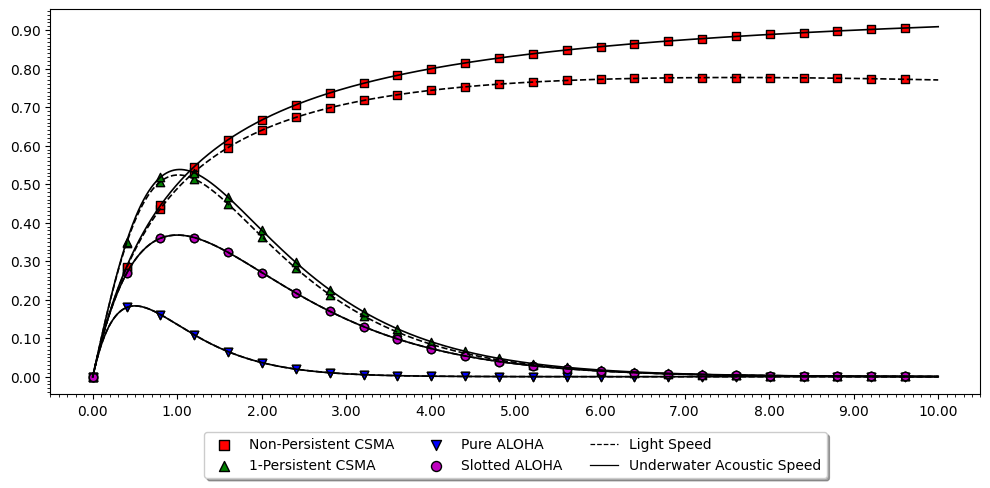

In [63]:
DEPTHS = [i for i in range(100, 10000, 50)]
G = np.linspace(0, 10, 1000)
colors = ['r', 'g', 'b', 'm', 'y', 'c', 'navy', 'maroon']
PROTOCOLS = ["non-persistent", "1-persistent", "aloha", "slotted-aloha"]
labels = ["Non-Persistent CSMA", "1-Persistent CSMA", "Pure ALOHA", "Slotted ALOHA"]
markers = ['s', '^', 'v', 'o', '>', '<', 'X', 'D']
fig, ax = plt.subplots(figsize=(12,5))
depth_protocol = {}
depth_protocol2 = {}
for protocol in PROTOCOLS:
    depth_protocol[protocol] = []
    depth_protocol2[protocol] = []
    for kc in G:
        a = ratio_delay(1000, 1000, 500)
        depth_protocol[protocol].append(throughput(a, protocol, kc))
        a2 = ratio_delay(1000, 1000, 500, True)
        depth_protocol2[protocol].append(throughput(a2, protocol, kc))

count = 0
hop = 40
for protocol in PROTOCOLS:
    ax.plot(G, depth_protocol[protocol] ,linestyle="--", color='k', linewidth=1.2)
    ax.plot(G, depth_protocol2[protocol]               , color='k', linewidth=1.2)
    ax.scatter(G[::hop], depth_protocol[protocol][::hop] , label=labels[count], marker=markers[count], edgecolor='k', color=colors[count])
    ax.scatter(G[::hop], depth_protocol2[protocol][::hop]                     , marker=markers[count], edgecolor='k', color=colors[count])
    count += 1

ax.plot(0, 0,linestyle="--", color='k', linewidth=0.9, label="Light Speed")
ax.plot(0, 0               , color='k', linewidth=0.9, label="Underwater Acoustic Speed")

ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_major_formatter('{x:.2f}')
ax.yaxis.set_minor_locator(MultipleLocator(0.01))
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_major_formatter('{x:.2f}')
ax.xaxis.set_minor_locator(MultipleLocator(0.1))
    
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),
              fancybox=True, shadow=True, ncol=3, markerscale=1.2, fontsize=10)
plt.show()

In [64]:
a = (np.max(np.array(depth_protocol['slotted-aloha'])))
print(f"a : {a:.2f}")

a : 0.37
